# Di-Higgs momentum regressor final training

## Import

### Import modules

In [1]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import root_numpy
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from __future__ import division
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../')
from Regression_Application import *

Couldn't import dot_parser, loading of dot files will not be possible.


Welcome to ROOTaaS 6.06/04


/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/root_numpy/__init__.py:35: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
dataVersion = "v1"
signalData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/MG5_pp_hh_bbtt_13TeV_10M_py8_" + dataVersion + ".root", treename = mode))
backgroundData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/PH_pp_tt_ll_13Tev_10M_py8_" + "v1" + ".root", treename = mode))
print "Samples contains", len(signalData), "signal events and", len(backgroundData), "background events"
print len(signalData)+len(backgroundData), "events in total"

Samples contains 71614 signal events and 103690 background events
175304 events in total


## Configure data

### Add classification targets and combine into single dataset

In [3]:
signalData["gen_target"] = 1
backgroundData["gen_target"] = 0
data = signalData.append(backgroundData, ignore_index = True)

In [4]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
rename = [var for var in data.columns if str.endswith(var, "_e")]
data.rename(columns=dict(zip(rename, [var[:var.rfind("_e")] + "_E" for var in rename])), inplace=True)
rename = [var for var in data.columns if str.startswith(var, "gen_hh")]
data.rename(columns=dict(zip(rename, ["gen_diH" + var[6:] for var in rename])), inplace=True)
data.rename(columns={'gen_m_hh' : 'gen_diH_mass'}, inplace=True)

### Create development and validation samples

In [5]:
sig_devIndeces, sig_valIndeces = train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()], test_size=0.2, random_state=1337)

### Move to cartesian coordinates

In [6]:
def moveToCartesian(inData, particle, z = True):
    pt = inData.ix[:, particle + "_pT"]
    if z: eta = inData.ix[:, particle + "_eta"]
    phi = inData.ix[:, particle + "_phi"]
    inData[particle + '_px'] = pt*np.cos(phi)
    inData[particle + '_py'] = pt*np.sin(phi)
    if z: inData[particle + '_pz'] = pt*np.sinh(eta)

In [7]:
moveToCartesian(data, 'gen_t_0')
moveToCartesian(data, 'gen_t_1')
moveToCartesian(data, 'gen_b_0')
moveToCartesian(data, 'gen_b_1')
moveToCartesian(data, 'gen_h_tt')
moveToCartesian(data, 'gen_h_bb')
moveToCartesian(data, 'gen_diH')
moveToCartesian(data, 't_0')
moveToCartesian(data, 't_1')
moveToCartesian(data, 'b_0')
moveToCartesian(data, 'b_1')
moveToCartesian(data, 'h_tt')
moveToCartesian(data, 'h_bb')
moveToCartesian(data, 'diH')
moveToCartesian(data, 'mPT', False)

### High-level variables

In [8]:
def deltaphi(a, b):
    return math.pi-np.abs(np.abs(a-b)-math.pi)

In [9]:
finalStates = ['b_0', 'b_1', 't_0', 't_1']
recoObjects = ['diH', 'h_bb', 'h_tt']
variables = ['px', 'py', 'pz']
for fs1 in finalStates:
    for fs2 in finalStates:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
for fs1 in recoObjects:
    for fs2 in recoObjects:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

### Apply regressors

In [10]:
bRegressor = BRegressor(data, "../bRegression/weights/NN_B_Regressor_App_" + mode + "_" + dataVersion, mode)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

10 components found in ensemble


In [11]:
tauRegressor = TauRegressor(data, "../tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_" + dataVersion, mode)
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

10 components found in ensemble


### Specify variables

In [12]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

In [13]:
globalKinFeatures = [var for var in trainFeatures if (str.startswith(var, "min")) or (str.startswith(var, "mean")) or (str.startswith(var, "max"))] + ['hT', 'sT', 'eVis']
globalMultiFeatures = [var for var in trainFeatures if (str.startswith(var, "n"))]
globalShapeFeatures = ['centrality', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA']
primaryShapeFeatures = ['sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP']
globalFeatures = globalKinFeatures + globalMultiFeatures + globalShapeFeatures
shapeFeatures = globalShapeFeatures + primaryShapeFeatures
pTEtaPhi = [var for var in trainFeatures if (str.endswith(var, "_pT")) or (str.endswith(var, "_phi")) or (str.endswith(var, "_eta"))]
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in globalFeatures + shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]

In [14]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs] + ['hl_mT']

## Specify options

In [15]:
regTrainFeatures = set0
regModel = 'model1'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']
print "\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures]
print "\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures]


Training on 45 features: ['b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 't_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'mPT_px', 'mPT_py', 'b_0_|p|', 'b_0_E', 'b_1_|p|', 'b_1_E', 't_0_|p|', 't_0_E', 't_1_|p|', 't_1_E', 'diH_mass', 'h_bb_mass', 'h_tt_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'h_bb_|p|', 'h_bb_E', 'h_tt_|p|', 'h_tt_E', 'hl_mT']

Regressing to 3 features: ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']


In [16]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print "{0} events for training, {1} events for validation".format(len(devData), len(valData))

49124 events for training, 126180 events for validation


## Define regressor

In [17]:
def getLayout(params):
    architecture = int(params[0])
    nodes = int(params[1])
    depth = int(params[2])
    layout = np.zeros(depth).astype(int)
    if architecture == 0: #Box: same number of nodes in each layer
        layout.fill(nodes)
    if architecture == 1: #Taper: linear reduction of width with depth
        coef = (len(regTargetFeatures)-nodes)/(depth+1)
        for l in range(depth):
            layout[l] = nodes+(coef*l)
    if architecture == 2: #Choke: linear reduction down to Noutputs at centre layer
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        coefInc = (nodes-len(regTargetFeatures))/(depth-centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)+(coefInc*(l-centre+1))
    if architecture == 3: #Funnel: linearly reduces to Noutputs at centre layer then moves to box layput
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)
    return layout

In [18]:
def getParameterisedRegressor(params):
    params = params.tolist()
    noise = params[0]
    dropout = params[1]
    layers = getLayout(params[2:])
    regModel = Sequential()
    regModel.add(Dense(int(layers[0]), input_dim=len(regTrainFeatures), init='glorot_normal'))
    regModel.add(PReLU())
    regModel.add(GaussianNoise(noise))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(dropout))
    for i in layers[1:]:
        if i < len(regTargetFeatures): break
        regModel.add(Dense(int(i), init='glorot_normal'))
        regModel.add(PReLU())
        regModel.add(GaussianNoise(noise))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(dropout))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', init='glorot_normal'))
    regModel.compile(loss='mse', optimizer='nadam')
    modelVersion = "model0"
    return regModel

In [19]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor(model):
    regModel = Sequential()
    if model == "model0":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model1":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model2":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model3":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model4":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_uniform'))
    elif model == "model5":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model6":
        regModel.add(Dense(150, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(120, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal')) 
    elif model == "model7":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model8":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model9":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model10":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Preprocess data

In [26]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [27]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [28]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [29]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [30]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print "Running fold", i, "/", nSplits
        model = None # Clearing the NN
        model = getRegressor(regModel)
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print "Score is:", results[-1]
        model.save('train_weights/train_' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print "Running fold", i+1, "/", nSplits
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print "Score is:", results[-1]
        model.save('train_weights/train_' + str(i) + '.h5')
with open('train_weights/resultsFile.pkl', 'w') as fout:
    pickle.dump(results, fout)
print "Cross-validation took {:.3f}s ".format(time.time() - start)
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00042: early stopping
Score is: {'loss': 0.019576038527379217}
Running fold 2 / 10
Epoch 00052: early stopping
Score is: {'loss': 0.019859557355278844}
Running fold 3 / 10
Epoch 00056: early stopping
Score is: {'loss': 0.018824527483701149}
Running fold 4 / 10
Epoch 00071: early stopping
Score is: {'loss': 0.0184432310047477}
Running fold 5 / 10
Epoch 00072: early stopping
Score is: {'loss': 0.018735133672697343}
Running fold 6 / 10
Epoch 00082: early stopping
Score is: {'loss': 0.01793543679536554}
Running fold 7 / 10
Epoch 00065: early stopping
Score is: {'loss': 0.018561531741062866}
Running fold 8 / 10
Epoch 00066: early stopping
Score is: {'loss': 0.021925357285680718}
Running fold 9 / 10
Epoch 00051: early stopping
Score is: {'loss': 0.018398480195588512}
Running fold 10 / 10
Epoch 00046: early stopping
Score is: {'loss': 0.022243297437406131}
Cross-validation took 1231.959s 
_________________________________________________________________
Layer (type) 

rm: cannot remove ‘train_weights/*.json’: No such file or directory
rm: cannot remove ‘train_weights/*.pkl’: No such file or directory


### Plot training histories

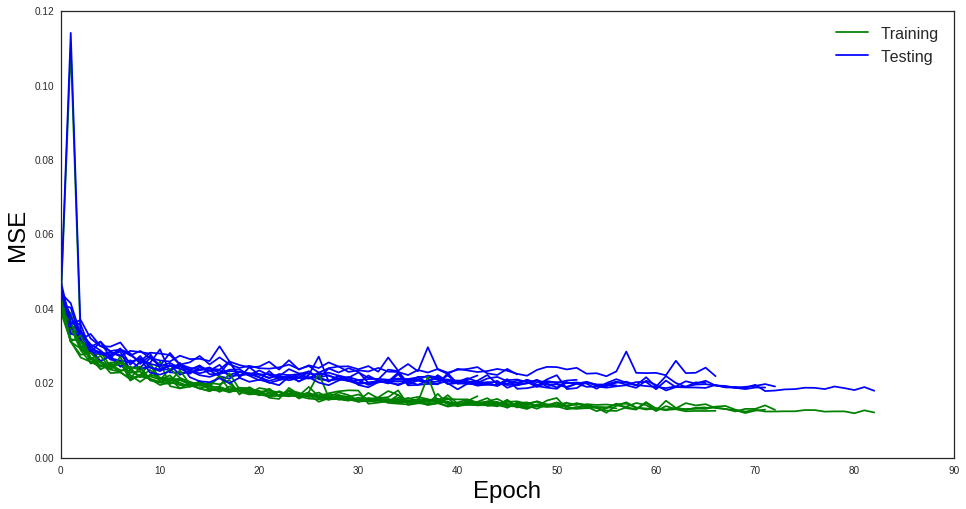

In [31]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [32]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [33]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [34]:
def getWeights(value, met):
    return 1/value

In [35]:
ensemble = []
weights = []
print "Choosing ensemble by", ensembleMode
if ensembleMode == 'mix':
    for met in results[0]:
        print "Choosing best for metric", met
        cycle = np.argmin([result[met] for result in results])
        print met, "Model", "is", cycle, "with", met, "=", results[cycle][met]
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print "Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result']
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 5 with loss = 0.0179354367954
Model 1 is 8 with loss = 0.0183984801956
Model 2 is 3 with loss = 0.0184432310047
Model 3 is 6 with loss = 0.0185615317411
Model 4 is 4 with loss = 0.0187351336727
Model 5 is 2 with loss = 0.0188245274837
Model 6 is 0 with loss = 0.0195760385274
Model 7 is 1 with loss = 0.0198595573553
Model 8 is 7 with loss = 0.0219253572857
Model 9 is 9 with loss = 0.0222432974374


## Response of ensemble on development data

###  Preprocess data

In [36]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [39]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    devData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=devData.index)

### Evaluate response

In [40]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.ix[sig, 'loss_d'] += np.square(devData.ix[sig, 'regHH_' + feature[4:]]-devData.ix[sig, feature])
print 'Ensemble on dev data:\n Loss = {}'.format(np.mean(devData.ix[sig, 'loss_d'])/len(regTargetFeatures))

Ensemble on dev data:
 Loss = 730.651888155


## Response of ensemble on validation data

###  Preprocess data

In [41]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [42]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    valData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=valData.index)

### Evaluate response

In [43]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.ix[sig, 'loss_v'] += np.square(valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature])
print 'Ensemble on val data:\n Loss = {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures))

Ensemble on val data:
 Loss = 1070.42290592


### Two-sample Kolmogorov–Smirnov test

In [44]:
for n, feature in enumerate(regTargetFeatures):
    print 
    print feature
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


gen_diH_px
K-S test result 0.0132, p-value of 0.2341

gen_diH_py
K-S test result 0.0101, p-value of 0.5565

gen_diH_pz
K-S test result 0.0044, p-value of 0.9998


### Di-Higgs momenta distribution


gen_diH_px

gen_diH_py

gen_diH_pz


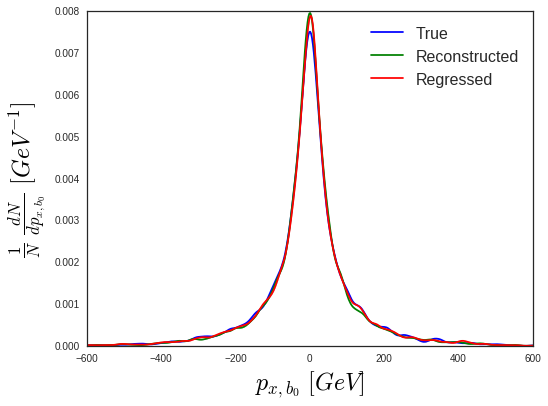

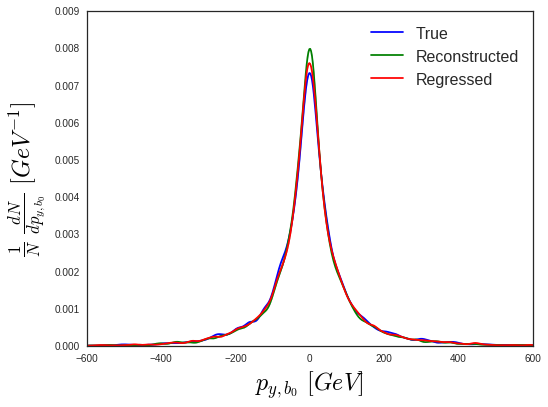

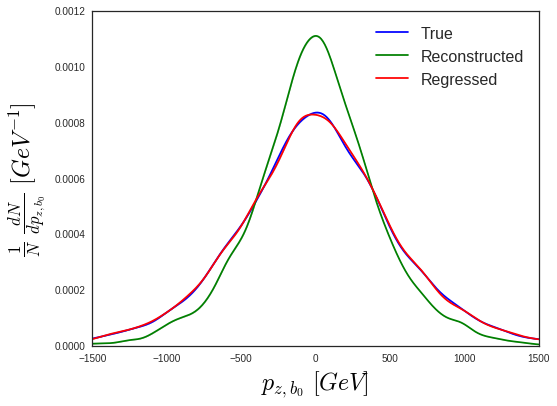

In [45]:
for n, feature in enumerate(regTargetFeatures):
    print 
    print feature
    plt.figure(figsize=(8, 6))
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    bootGen = []
    meanBootGen = []
    stdevBootGen = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature].values, len(valData[sig]), replace=True)
        meanBootGen.append(points.mean())
        stdevBootGen.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        bootGen.append([kde.evaluate(x) for x in xPlot])
    meanGen = (np.mean(meanBootGen), np.std(meanBootGen)/math.sqrt(len(meanBootGen)))
    stdevGen = (np.mean(stdevBootGen), np.std(stdevBootGen)/math.sqrt(len(stdevBootGen)))
    sns.tsplot(data=bootGen, time=xPlot, condition='True', color='b')
    bootRec = []
    meanBootRec = []
    stdevBootRec = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBootRec.append(points.mean())
        stdevBootRec.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        bootRec.append([kde.evaluate(x) for x in xPlot])
    meanRec = (np.mean(meanBootRec), np.std(meanBootRec)/math.sqrt(len(meanBootRec)))
    stdevRec = (np.mean(stdevBootRec), np.std(stdevBootRec)/math.sqrt(len(stdevBootRec)))
    sns.tsplot(data=bootRec, time=xPlot, condition='Reconstructed', color='g')
    bootReg = []
    meanBootReg = []
    stdevBootReg = []
    for i in range(100):
        points = np.random.choice(valData[sig]["regHH_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBootReg.append(points.mean())
        stdevBootReg.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        bootReg.append([kde.evaluate(x) for x in xPlot])
    meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
    stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
    sns.tsplot(data=bootReg, time=xPlot, condition='Regressed', color='r')
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Momentum pull distributions

	Feature	mean					sigma
Reco:	diH_px	0.306731385581 +- 0.0278194336714	31.814139364 +- 0.110455684729
HH Reg:	diH_px	-0.212859864616 +- 0.0259495745716	27.6206340382 +- 0.0582470331744
HH Reg:	diH_px	-0.407942691237 +- 0.0152059695997	17.7168740683 +- 0.0429836024931
HH Reg:	diH_px	0.98988183899 +- 0.0142327066228	16.811763948 +- 0.0362738093326
Reco:	diH_py	-0.141509953027 +- 0.0302384998123	31.0117080415 +- 0.096026931762
HH Reg:	diH_py	-0.107088248114 +- 0.0247324173311	26.9289691334 +- 0.0570780570344
HH Reg:	diH_py	-0.662402573118 +- 0.0159127184957	17.3284614186 +- 0.0251792214075
HH Reg:	diH_py	0.118350398282 +- 0.0152848257956	16.6832530883 +- 0.0288811282663
Reco:	diH_pz	-1.07425565283 +- 0.150387470718	172.40862377 +- 0.186072175282
HH Reg:	diH_pz	0.955620475863 +- 0.148788277471	153.320587937 +- 0.161672577144
HH Reg:	diH_pz	0.303944513854 +- 0.0425050292151	42.8418721711 +- 0.071363180624
HH Reg:	diH_pz	-1.96548793149 +- 0.0494979215144	51.4606195862 +- 0.0750291058583


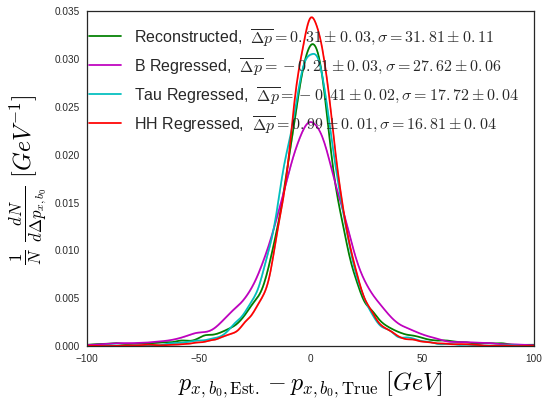

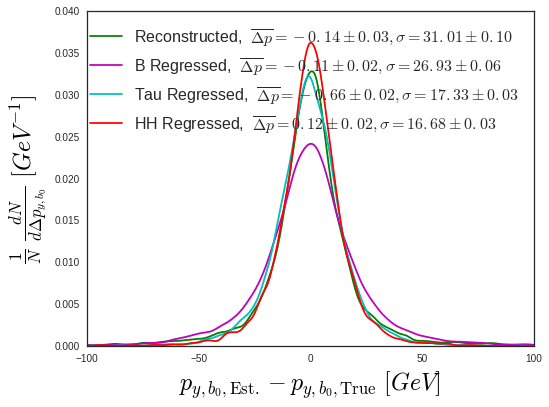

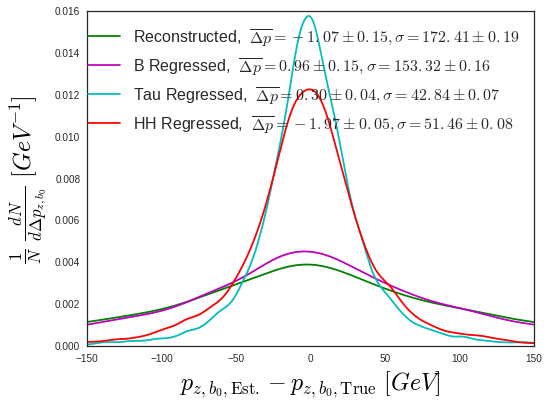

In [46]:
print "\tFeature\tmean\t\t\t\t\tsigma"
for n, feature in enumerate(regTargetFeatures):
    plt.figure(figsize=(8, 6))
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig][feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        boot.append([kde.evaluate(x) for x in xPlot])
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=boot, time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['regB_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        boot.append([kde.evaluate(x) for x in xPlot])
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print "HH Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=boot, time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['regTau_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        boot.append([kde.evaluate(x) for x in xPlot])
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print "HH Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=boot, time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['regHH_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
        kde = sm.nonparametric.KDEUnivariate(points)
        kde.fit()
        boot.append([kde.evaluate(x) for x in xPlot])
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print "HH Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=boot, time=xPlot,
               condition=r'HH Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='r')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

## Save/load

In [ ]:
name = "weights/NN_HH_Mom_Regressor_App_" + mode + "_" + dataVersion
print name

### Save

In [ ]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'w') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'w') as fout:
    pickle.dump(outputPipe, fout)

### Load

In [ ]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
#compileArgs = None
'''with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)'''
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name  + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)